In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

In [80]:
df = pd.read_csv('data_correlation_gone.csv',index_col = 0)

In [82]:
df['price'].mean()

541639.8338275844

In [83]:
df['price'].std()

372247.7873124794

In [3]:
check_col = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','distance_from_a_city']

In [4]:
def remove_outliers(df, col, threshold = 3):
    zscores = scs.zscore(df[col])
    indices = np.abs(np.where(zscores > threshold))
    return indices[0]


all_indices = []
for col in check_col:
    indices = remove_outliers(df, col, threshold = 3)
    all_indices.extend(indices)
all_indices = np.unique(all_indices)

In [5]:
df.reset_index(drop=True,inplace=True)

In [6]:
df.drop(all_indices,axis=0,inplace= True)

In [7]:
df = df.loc[df['condition']>=3]

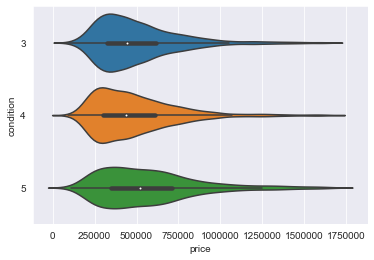

In [8]:
sns.violinplot(x='price', y='condition', data=df, orient='h')
plt.show()

In [9]:
df = df.round({'bathrooms':0})

In [10]:
df['cond3'] = df.condition.apply(lambda x: 1 if x ==3 else 0)
df['cond4'] = df.condition.apply(lambda x: 1 if x ==4 else 0)
df['cond5'] = df.condition.apply(lambda x: 1 if x ==5 else 0)

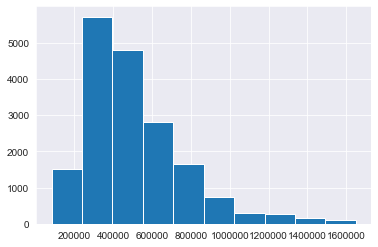

In [11]:
df['price'].hist()

In [12]:
features =  ['sqft_living','Age_of_House', 'Years_last_renovation','distance_from_a_city','sqft_lot']

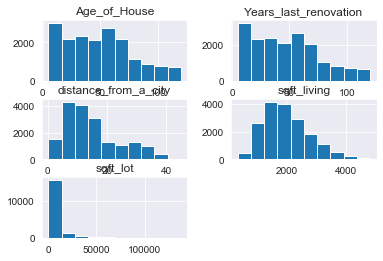

In [13]:
df[features].hist();

In [14]:
tobox =['sqft_living','Age_of_House', 'Years_last_renovation','distance_from_a_city','sqft_lot']

In [15]:
for feat in tobox:
    df[feat],b = scs.boxcox(df[feat])


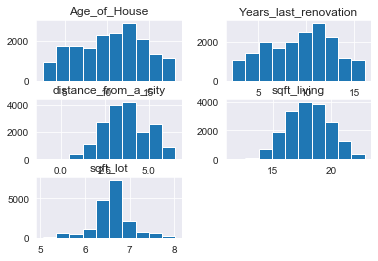

In [16]:
df[features].hist();

In [17]:
def norm_feat(series):
    return (series - series.mean())/series.std()

In [18]:
df['bedbath'] = df['bedrooms']*df['bathrooms']

In [19]:
df['livinglot'] = df['sqft_living']*df['sqft_lot']

In [20]:
norm = ['bedrooms','bathrooms','sqft_living','sqft_lot','distance_from_a_city','Age_of_House',
           'Years_last_renovation','bedbath','livinglot']


In [21]:
for feat in norm:
    df[feat] = norm_feat(df[feat])


In [22]:
# tomodel = ['distance_from_a_city','Years_last_renovation','sqft_living']

In [23]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'zipcode',
       'Age_of_House', 'Years_last_renovation', 'basement', 'biggerliving',
       'biggerlot', 'distance_from_a_city', 'distance_from_airport', 'cond3',
       'cond4', 'cond5', 'bedbath', 'livinglot'],
      dtype='object')

In [24]:
# x_cols = ['bedrooms','bathrooms','sqft_living','sqft_lot','distance_from_a_city',
#            'Age_of_House','basement','bedbath','grade']
# outcome = ['price']

In [25]:
x_cols = ['bedrooms','bathrooms','sqft_living','distance_from_a_city',
           'basement','grade']
outcome = ['price']

In [26]:
# x_cols = ['bedrooms','bathrooms','sqft_living','sqft_lot','distance_from_a_city',
#            'basement', 'cond3',
#        'cond4', 'cond5']
# outcome = ['price']

In [27]:
X = df[x_cols]
y = df['price']

In [28]:
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                          4.547e+04
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                        0.00
Time:                        15:06:40   Log-Likelihood:                     -2.3951e+05
No. Observations:               18042   AIC:                                  4.790e+05
Df Residuals:                   18036   BIC:                                  4.791e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
bedrooms             -1.803e+04   1364.864    -13.213      0.000   -2.07e+04   -1.54e+04
bathrooms             5401.2947   1397.343      3.865      0.000    2662.368    8140.221
sqft_living           1.193e+05   1591.785     74.977      0.000    1.16e+05    1.22e+05
distance_from_a_city  -1.23e+05   1081.026   -113.769      0.000   -1.25e+05   -1.21e+05
basement             -2.106e+04   2236.164     -9.420      0.000   -2.54e+04   -1.67e+04
grade                 6.762e+04    175.150    386.071      0.000    6.73e+04     6.8e+04
==============================================================================
Omnibus:                     4225.770   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14807.456
Skew:                           1.158   Prob(JB):                         0.00
Kurtosis:                       6.786   Cond. No.                         16.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

6 6
['bedrooms', 'bathrooms', 'sqft_living', 'distance_from_a_city', 'basement']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
bedrooms,-1.803e+04,1364.864,-13.213,0.0,-2.07e+04,-1.54e+04
bathrooms,5401.2947,1397.343,3.865,0.0,2662.368,8140.221
sqft_living,1.193e+05,1591.785,74.977,0.0,1.16e+05,1.22e+05
distance_from_a_city,-1.23e+05,1081.026,-113.769,0.0,-1.25e+05,-1.21e+05
basement,-2.106e+04,2236.164,-9.420,0.0,-2.54e+04,-1.67e+04


In [30]:
X = df[x_cols]
y= df['price']

In [31]:
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                          4.547e+04
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                        0.00
Time:                        15:06:43   Log-Likelihood:                     -2.3951e+05
No. Observations:               18042   AIC:                                  4.790e+05
Df Residuals:                   18036   BIC:                                  4.791e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
bedrooms             -1.803e+04   1364.864    -13.213      0.000   -2.07e+04   -1.54e+04
bathrooms             5401.2947   1397.343      3.865      0.000    2662.368    8140.221
sqft_living           1.193e+05   1591.785     74.977      0.000    1.16e+05    1.22e+05
distance_from_a_city  -1.23e+05   1081.026   -113.769      0.000   -1.25e+05   -1.21e+05
basement             -2.106e+04   2236.164     -9.420      0.000   -2.54e+04   -1.67e+04
grade                 6.762e+04    175.150    386.071      0.000    6.73e+04     6.8e+04
==============================================================================
Omnibus:                     4225.770   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14807.456
Skew:                           1.158   Prob(JB):                         0.00
Kurtosis:                       6.786   Cond. No.                         16.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
# Your code here - Code a way to identify multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[x_cols]
vif = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
list(zip(x_cols,vif))

[('bedrooms', 1.6903439939330218),
 ('bathrooms', 1.7717504582265786),
 ('sqft_living', 2.2991384873085607),
 ('distance_from_a_city', 1.0603973588385995),
 ('basement', 1.7373827437755536),
 ('grade', 1.6388489010050231)]

In [33]:
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5.5]
print(len(vif_scores), len(x_cols))

6 6


In [34]:
X = df[x_cols]
y= df['price']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                          4.547e+04
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                        0.00
Time:                        15:06:45   Log-Likelihood:                     -2.3951e+05
No. Observations:               18042   AIC:                                  4.790e+05
Df Residuals:                   18036   BIC:                                  4.791e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
bedrooms             -1.803e+04   1364.864    -13.213      0.000   -2.07e+04   -1.54e+04
bathrooms             5401.2947   1397.343      3.865      0.000    2662.368    8140.221
sqft_living           1.193e+05   1591.785     74.977      0.000    1.16e+05    1.22e+05
distance_from_a_city  -1.23e+05   1081.026   -113.769      0.000   -1.25e+05   -1.21e+05
basement             -2.106e+04   2236.164     -9.420      0.000   -2.54e+04   -1.67e+04
grade                 6.762e+04    175.150    386.071      0.000    6.73e+04     6.8e+04
==============================================================================
Omnibus:                     4225.770   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14807.456
Skew:                           1.158   Prob(JB):                         0.00
Kurtosis:                       6.786   Cond. No.                         16.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

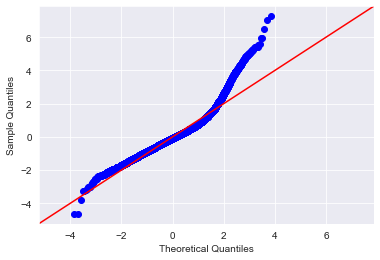

In [35]:
fig = sm.graphics.qqplot(model.resid, dist=scs.norm, line='45', fit=True)


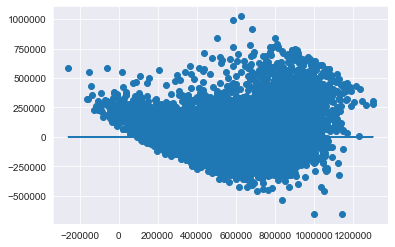

In [36]:
plt.scatter(model.predict(X), model.resid)
plt.plot(model.predict(X), [0 for i in range(len(df))])

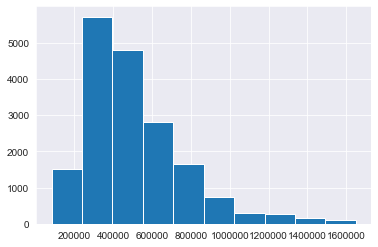

In [37]:
df.price.hist()

In [38]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df.price.quantile(q=q)))

0.8 percentile: 679950.0
0.81 percentile: 691000.0
0.82 percentile: 703185.9999999997
0.83 percentile: 718000.0
0.84 percentile: 730000.44
0.85 percentile: 749500.0
0.86 percentile: 760000.0
0.87 percentile: 778994.39
0.88 percentile: 795196.8399999999
0.89 percentile: 813745.0
0.9 percentile: 835000.0
0.91 percentile: 855426.610000001
0.92 percentile: 882997.2
0.93 percentile: 914652.0000000003
0.94 percentile: 950000.0
0.95 percentile: 994000.0
0.96 percentile: 1060000.0
0.97 percentile: 1160000.0
0.98 percentile: 1260000.0
0.99 percentile: 1400000.0


In [39]:
orig_tot = len(df)
df = df[df.price < 1150000.0] # Subsetting to remove extreme outliers
print('Percent removed:', (orig_tot -len(df))/orig_tot)


Percent removed: 0.03203635960536526


In [40]:
X = df[x_cols]
y = df['price']

In [41]:
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                          5.706e+04
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                        0.00
Time:                        15:07:12   Log-Likelihood:                     -2.2823e+05
No. Observations:               17464   AIC:                                  4.565e+05
Df Residuals:                   17458   BIC:                                  4.565e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
bedrooms             -1.247e+04   1135.044    -10.983      0.000   -1.47e+04   -1.02e+04
bathrooms            -1284.2642   1177.009     -1.091      0.275   -3591.319    1022.790
sqft_living           9.924e+04   1336.560     74.248      0.000    9.66e+04    1.02e+05
distance_from_a_city -1.068e+05    906.896   -117.796      0.000   -1.09e+05   -1.05e+05
basement             -1.721e+04   1853.828     -9.284      0.000   -2.08e+04   -1.36e+04
grade                 6.529e+04    145.984    447.246      0.000     6.5e+04    6.56e+04
==============================================================================
Omnibus:                     1054.995   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1706.038
Skew:                           0.492   Prob(JB):                         0.00
Kurtosis:                       4.173   Cond. No.                         16.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

6 5
['bedrooms', 'sqft_living', 'distance_from_a_city', 'basement', 'grade']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
bedrooms,-1.247e+04,1135.044,-10.983,0.000,-1.47e+04,-1.02e+04
bathrooms,-1284.2642,1177.009,-1.091,0.275,-3591.319,1022.790
sqft_living,9.924e+04,1336.560,74.248,0.000,9.66e+04,1.02e+05
distance_from_a_city,-1.068e+05,906.896,-117.796,0.000,-1.09e+05,-1.05e+05
basement,-1.721e+04,1853.828,-9.284,0.000,-2.08e+04,-1.36e+04


In [43]:
X = df[x_cols]
y= df['price']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                          6.847e+04
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                        0.00
Time:                        15:07:16   Log-Likelihood:                     -2.2823e+05
No. Observations:               17464   AIC:                                  4.565e+05
Df Residuals:                   17459   BIC:                                  4.565e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
bedrooms             -1.259e+04   1129.756    -11.140      0.000   -1.48e+04   -1.04e+04
sqft_living           9.851e+04   1159.572     84.956      0.000    9.62e+04    1.01e+05
distance_from_a_city -1.068e+05    906.181   -117.845      0.000   -1.09e+05   -1.05e+05
basement             -1.738e+04   1847.486     -9.406      0.000    -2.1e+04   -1.38e+04
grade                  6.53e+04    145.791    447.897      0.000     6.5e+04    6.56e+04
==============================================================================
Omnibus:                     1053.704   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1705.563
Skew:                           0.492   Prob(JB):                         0.00
Kurtosis:                       4.174   Cond. No.                         16.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# Your code here - Code a way to identify multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[x_cols]
vif = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
list(zip(x_cols,vif))

[('bedrooms', 1.6757229338094273),
 ('sqft_living', 1.6908239914502372),
 ('distance_from_a_city', 1.0659979767531438),
 ('basement', 1.7026164276104312),
 ('grade', 1.631266082405322)]

In [45]:
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

5 5


In [46]:
X = df[x_cols]
y= df['price']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                          6.847e+04
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                        0.00
Time:                        15:07:18   Log-Likelihood:                     -2.2823e+05
No. Observations:               17464   AIC:                                  4.565e+05
Df Residuals:                   17459   BIC:                                  4.565e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
bedrooms             -1.259e+04   1129.756    -11.140      0.000   -1.48e+04   -1.04e+04
sqft_living           9.851e+04   1159.572     84.956      0.000    9.62e+04    1.01e+05
distance_from_a_city -1.068e+05    906.181   -117.845      0.000   -1.09e+05   -1.05e+05
basement             -1.738e+04   1847.486     -9.406      0.000    -2.1e+04   -1.38e+04
grade                  6.53e+04    145.791    447.897      0.000     6.5e+04    6.56e+04
==============================================================================
Omnibus:                     1053.704   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1705.563
Skew:                           0.492   Prob(JB):                         0.00
Kurtosis:                       4.174   Cond. No.                         16.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

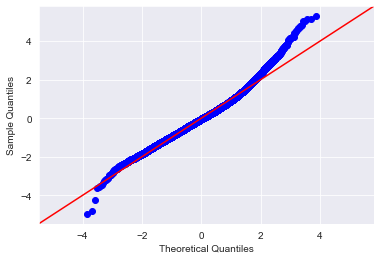

In [47]:
fig = sm.graphics.qqplot(model.resid, dist=scs.norm, line='45', fit=True)


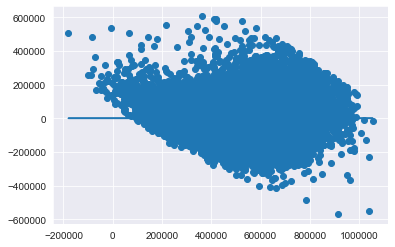

In [48]:
plt.scatter(model.predict(X), model.resid)
plt.plot(model.predict(X), [0 for i in range(len(df))])

In [49]:
df = df[df.price <= 750000.0]


In [50]:
X =df[x_cols]
y=df['price']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                          6.771e+04
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                        0.00
Time:                        15:07:28   Log-Likelihood:                     -1.9845e+05
No. Observations:               15422   AIC:                                  3.969e+05
Df Residuals:                   15417   BIC:                                  3.970e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
bedrooms             -1.026e+04   1004.349    -10.216      0.000   -1.22e+04   -8291.584
sqft_living           6.935e+04   1092.101     63.500      0.000    6.72e+04    7.15e+04
distance_from_a_city -8.505e+04    817.380   -104.048      0.000   -8.66e+04   -8.34e+04
basement             -9497.8711   1635.362     -5.808      0.000   -1.27e+04   -6292.369
grade                 6.106e+04    135.268    451.382      0.000    6.08e+04    6.13e+04
==============================================================================
Omnibus:                      172.373   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.129
Skew:                           0.210   Prob(JB):                     1.56e-43
Kurtosis:                       3.360   Cond. No.                         16.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

5 5
['bedrooms', 'sqft_living', 'distance_from_a_city', 'basement', 'grade']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
bedrooms,-1.026e+04,1004.349,-10.216,0.0,-1.22e+04,-8291.584
sqft_living,6.935e+04,1092.101,63.500,0.0,6.72e+04,7.15e+04
distance_from_a_city,-8.505e+04,817.380,-104.048,0.0,-8.66e+04,-8.34e+04
basement,-9497.8711,1635.362,-5.808,0.0,-1.27e+04,-6292.369
grade,6.106e+04,135.268,451.382,0.0,6.08e+04,6.13e+04


In [52]:
X = df[x_cols]
y= df['price']
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                          6.771e+04
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                        0.00
Time:                        15:07:31   Log-Likelihood:                     -1.9845e+05
No. Observations:               15422   AIC:                                  3.969e+05
Df Residuals:                   15417   BIC:                                  3.970e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
bedrooms             -1.026e+04   1004.349    -10.216      0.000   -1.22e+04   -8291.584
sqft_living           6.935e+04   1092.101     63.500      0.000    6.72e+04    7.15e+04
distance_from_a_city -8.505e+04    817.380   -104.048      0.000   -8.66e+04   -8.34e+04
basement             -9497.8711   1635.362     -5.808      0.000   -1.27e+04   -6292.369
grade                 6.106e+04    135.268    451.382      0.000    6.08e+04    6.13e+04
==============================================================================
Omnibus:                      172.373   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.129
Skew:                           0.210   Prob(JB):                     1.56e-43
Kurtosis:                       3.360   Cond. No.                         16.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

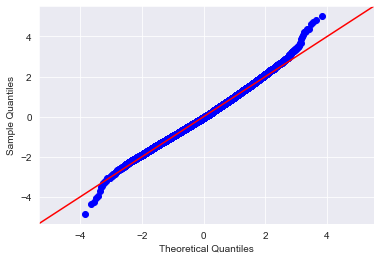

In [53]:
fig = sm.graphics.qqplot(model.resid, dist=scs.norm, line='45', fit=True)


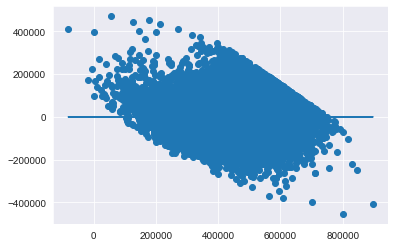

In [54]:
plt.scatter(model.predict(X), model.resid)
plt.plot(model.predict(X), [0 for i in range(len(df))])

In [55]:
def plot_residuals(resids):
    plt.hist(resids)
    plt.title("Residuals")
    plt.show()
    
    xspace = np.linspace(0, 1, len(resids))
    plt.scatter(xspace, resids)
    plt.title("resids")
    plt.hlines(0, xmin=0, xmax=1)
    plt.show()

In [56]:
residuals = model.resid

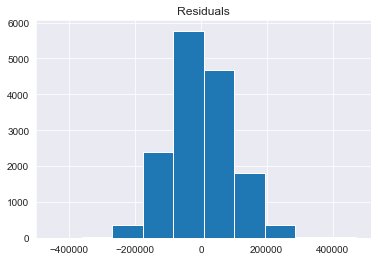

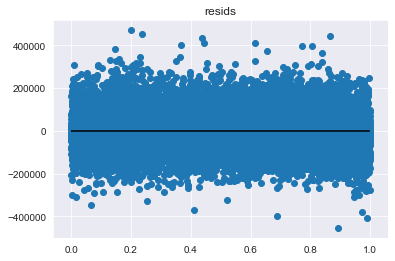

In [57]:
plot_residuals(residuals)

In [58]:
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from sklearn.metrics import r2_score

In [59]:
ols = LinearRegression(fit_intercept=False, normalize=False, n_jobs=-1)

In [60]:
cv5_scores = np.mean(cross_val_score(ols, X, y, scoring='r2', cv=5, n_jobs=-1) )
cv10_scores = np.mean(cross_val_score(ols, X, y, scoring='r2', cv=10, n_jobs=-1) )
cv20_scores = np.mean(cross_val_score(ols, X, y, scoring='r2', cv=20, n_jobs=-1) )

# cv breaks your data into that many equal pieces 
cv5_scores,cv10_scores,cv20_scores

(0.6038194257761105, 0.600491080338956, 0.6011478863983257)

In [61]:
cv5mae_scores = np.mean(cross_val_score(ols, X, y, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1) )
cv10mae_scores = np.mean(cross_val_score(ols, X, y, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1) )
cv20mae_scores = np.mean(cross_val_score(ols, X, y, scoring='neg_mean_absolute_error', cv=20, n_jobs=-1) )

# cv breaks your data into that many equal pieces 
cv5mae_scores,cv10mae_scores,cv20mae_scores

(-74378.50346668862, -74396.63784938955, -74268.58481672534)

In [62]:
X_shuff, y_shuff = shuffle(X, y)
cv_scores = cross_val_score(ols, X_shuff, y_shuff, scoring='r2', cv=5, n_jobs=-1) 
cv_scores.mean()

0.6081256359691003

In [63]:
def make_ols_sklearn(X, y, test_size=0.20, fit_intercept=False, standardize=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    if standardize:
        ss = StandardScaler()
        ss.fit(X_train)
        X_train = ss.transform(X_train)
        X_test = ss.transform(X_test)
    ols = LinearRegression(fit_intercept=fit_intercept, normalize=False)
    ols.fit(X_train, y_train)
    train_score = ols.score(X_train, y_train)
    test_score = ols.score(X_test, y_test)
    cv5_scores = np.mean(cross_val_score(ols, X, y, scoring='r2', cv=5, n_jobs=-1) )
    cv10_scores = np.mean(cross_val_score(ols, X, y, scoring='r2', cv=10, n_jobs=-1) )
    cvmse_5 = np.mean(cross_val_score(ols,X , y, cv=5, scoring='neg_mean_squared_error'))
    cvmse_10 = np.mean(cross_val_score(ols,X, y, cv=10, scoring='neg_mean_squared_error'))
    print(f"train R2 score = {train_score}")
    print(f"test R2 score = {test_score}")
    print(f"cv5 R2 score = {cv5_scores}")
    print(f"cv10 R2 score = {cv10_scores}")
    print(f"cv5 MSE score = {cvmse_5}")
    print(f"cv10  MSE score = {cvmse_10}")

    return ols

In [64]:
make_ols_sklearn(X, y)

train R2 score = 0.6098970052038297
test R2 score = 0.6031770290084271
cv5 R2 score = 0.6038194257761105
cv10 R2 score = 0.600491080338956
cv5 MSE score = -8868683134.891024
cv10  MSE score = -8875707202.081081


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [68]:
make_ols_sklearn(X, y)

train R2 score = 0.6098434825300391
test R2 score = 0.6034725273670816
cv5 R2 score = 0.6038194257761105
cv10 R2 score = 0.600491080338956
cv5 MSE score = -8868683134.891024
cv10  MSE score = -8875707202.081081


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [69]:
residuals = model.resid

In [70]:
resid = pd.DataFrame(df['price'])

In [71]:
resid['residuals']  = residuals

In [72]:
resid

,price,residuals
0,538000.0,56189.106427
1,180000.0,-45720.250193
2,604000.0,161430.191919
3,510000.0,23723.295106
5,257500.0,-18520.162744
...,...,...
19216,475000.0,-29541.930601
19217,360000.0,-127717.053978
19218,400000.0,-138200.176762
19219,402101.0,-96685.683868


In [73]:
import seaborn as sns

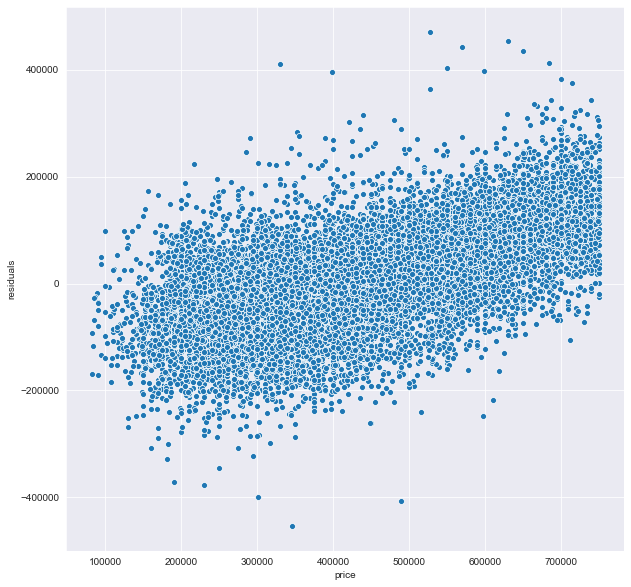

In [74]:
plt.figure(figsize= (10,10))

sns.scatterplot(y='residuals',x='price',data=resid)

In [75]:
X_shuff, y_shuff = shuffle(X, y)

In [76]:
X_shuff, y_shuff = shuffle(X, y)
cv_scores = cross_val_score(ols, X_shuff, y_shuff, scoring='r2', cv=5, n_jobs=-1) 
cv_scores.mean()

0.6083216625338194

In [77]:
X_shuff, y_shuff = shuffle(X, y)
cv_scores = cross_val_score(ols, X_shuff, y_shuff, scoring='r2', cv=5, n_jobs=-1) 
cv_scores.mean()

0.6082563244599728

In [78]:
X_shuff, y_shuff = shuffle(X, y)
cv_scores = cross_val_score(ols, X_shuff, y_shuff, scoring='r2', cv=5, n_jobs=-1) 
cv_scores.mean()

0.6079347487601048

In [189]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white